## Week8 - Session 2: Markov Decision Process (MDP) - Random Features

install mdptoolbox: pip install pymdptoolbox or refer to the link: https://pymdptoolbox.readthedocs.io/en/latest/

In [1]:
import numpy as np
import pandas as pd
import mdptoolbox, mdptoolbox.example
import argparse
import math
from MDP_policy import *
import random
import warnings
warnings.filterwarnings('ignore')

### Part 1. Load Data

In [2]:
# Load data
org_data = pd.read_csv('MDP_data_student200.csv')

# Define different feature sets: feature_space(total), static_feats, candidate_feats
feature_space = list(org_data.columns.values)
static_feats, candidate_feats = feature_space[:6], feature_space[6:]

# Report the number of features.
print("# static features: {}".format(len(static_feats)))
print("# candidate features: {}\n".format(len(candidate_feats)))

org_data.head(3)

# static features: 6
# candidate features: 124



,student,currProb,course,session,priorTutorAction,reward,Interaction,hintCount,TotalTime,TotalPSTime,...,cumul_NextStepClickCountWE,cumul_PreviousStepClickCountWE,cumul_deletedApp,CurrPro_NumProbRule,CurrPro_avgProbTime,CurrPro_avgProbTimePS,CurrPro_avgProbTimeDeviationPS,CurrPro_avgProbTimeWE,CurrPro_avgProbTimeDeviationWE,CurrPro_medianProbTime
0,0006-F14,1.0.1.0,226-001-BARNES-F14,1,PS,0.0,47,0,535.244,535.244,...,0,0,0,3,472.529142,402.247660,754.222657,48.043621,85.893332,226.8775
1,0006-F14,1.0.2.0,226-001-BARNES-F14,1,WE,0.0,12,0,56.759,0.000,...,5,0,0,3,167.952813,136.653564,325.619923,25.727113,44.427446,81.4950
2,0006-F14,1.0.3.0,226-001-BARNES-F14,1,WE,0.0,6,0,6.695,0.000,...,10,0,0,4,572.535163,522.227282,1017.360329,23.751811,45.742236,124.3650


### Part 2. Discretization

In [3]:
# Extract continuous features for discretization
#  - we consider features with more than 6 distinct values continous, except for the 'object' type features.

# > get column names, types, # of unique values
col_names = list(org_data.columns.values)
col_types = list(org_data.dtypes.astype('str'))

col_numval = []
for col in col_names:
    numval = len(org_data[col].unique())
    col_numval.append(numval)

# > generate a dataframe for extraction
col_dict = {'name': col_names, 'type': col_types, 'uniqueval': col_numval}
col_data = pd.DataFrame(col_dict, columns=['name', 'type', 'uniqueval'])

# > extract features which satisfy the condition
n_bins = 2
condition = (col_data['uniqueval'] > n_bins)
continuous_feats = col_data[condition].name.tolist()
continuous_feats = [i for i in continuous_feats if i not in static_feats]

# > print the number of selected features
print("# continuous features: {}".format(len(continuous_feats)))

# Discretize the continuous features 
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal')#, strategy='uniform')

new_data = org_data.copy()

# for col in continuous_feats:
for col in candidate_feats:
    data_reshaped = np.reshape(np.array(org_data[col]), (-1, 1))
    new_data[col] = enc.fit_transform(data_reshaped)
    
new_data.head(3)

# continuous features: 113


,student,currProb,course,session,priorTutorAction,reward,Interaction,hintCount,TotalTime,TotalPSTime,...,cumul_NextStepClickCountWE,cumul_PreviousStepClickCountWE,cumul_deletedApp,CurrPro_NumProbRule,CurrPro_avgProbTime,CurrPro_avgProbTimePS,CurrPro_avgProbTimeDeviationPS,CurrPro_avgProbTimeWE,CurrPro_avgProbTimeDeviationWE,CurrPro_medianProbTime
0,0006-F14,1.0.1.0,226-001-BARNES-F14,1,PS,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0006-F14,1.0.2.0,226-001-BARNES-F14,1,WE,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0006-F14,1.0.3.0,226-001-BARNES-F14,1,WE,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Part 3. Feature Selection

In [4]:
%%time
x = []
y = []
feature_sets = {}
can_size = len(candidate_feats)

# line 1-3
for k in range(1, 9):
    print("{} selected:".format(k), end=" ")
    # random select k features from the candidate feature set.
    chosen_feats = random.sample(candidate_feats, k)
    # store the chosen feature set in a dictionary
    feature_sets[k] = chosen_feats
    print(chosen_feats, end=" ")
    
    sample_feats = static_feats + chosen_feats
    sample_data = new_data[sample_feats]
    
    # load data set with selected or extracted discrete features
    [start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)
    
    # apply Value Iteration to run the MDP
    try:
        vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
        vi.run()

        # evaluate policy using ECR
        ecr = calcuate_ECR(start_states, vi.V)
        print("-> ECR: {}\n".format(ecr))
        
        x.append(k)
        y.append(ecr)
        
    except OverflowError:
        print("Error occured!\n")
        pass

1 selected: ['difficultProblemCountWE'] -> ECR: 1.12427028807316

2 selected: ['NextStepClickCountWE', 'ruleScoreIMPL'] -> ECR: 10.874076160372319

3 selected: ['RuleTypesCount', 'OptionalCount', 'ruleScoreCONJ'] -> ECR: 10.890369936651288

4 selected: ['UseCount', 'cumul_BlankRatio', 'ruleScoreMP', 'cumul_RuleTypesCount'] -> ECR: 15.018006706952104

5 selected: ['cumul_F1Score', 'cumul_PreviousStepClickCountWE', 'easyProblemCountWE', 'cumul_symbolicRepresentationCount', 'cumul_RightApp'] -> ECR: 16.08690645188437

6 selected: ['ruleScoreABS', 'ruleScoreCD', 'ruleScoreDEM', 'CurrPro_NumProbRule', 'ruleScoreCONJ', 'cumul_avgstepTimePS'] -> ECR: 13.784709674592262

7 selected: ['SeenWEinLevel', 'cumul_hintRatio', 'cumul_easyProblemCountSolved', 'difficultProblemCountWE', 'cumul_TotalWETime', 'stepTimeDeviation', 'ruleScoreDS'] -> ECR: 12.295146969545694

8 selected: ['CurrPro_avgProbTimePS', 'stepTimeDeviation', 'InterfaceErrorCount', 'easyProblemCountWE', 'cumul_InterfaceErrorCount', 'r

### Result : Random Feature Selection

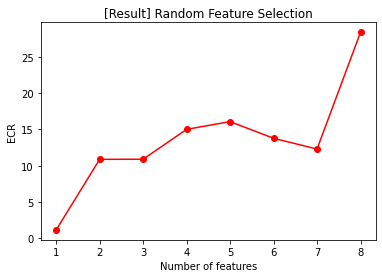

In [5]:
import matplotlib.pyplot as plt

plt.plot(x, y, 'ro-')
plt.title('[Result] Random Feature Selection')
plt.xlabel('Number of features')
plt.ylabel('ECR')
plt.show()

### Part 4. Induce Policy with the best feature set

In [6]:
# feature counts with the highest ECR.
best_k = 8

sample_feats = static_feats + feature_sets[best_k]
sample_data = new_data[sample_feats]

# load data set with selected or extracted discrete features
[start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)

# apply Value Iteration to run the MDP
try:
    vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
    vi.run()
    
    # output policy
    output_policy(distinct_acts, distinct_states, vi)

except OverflowError:
    print("Error occured!\n")
    pass

Policy: 
state -> action, value-function
0.0:0.0:0.0:0.0:1.0:0.0:0.0:0.0 -> WE, 10.577791380830067
1.0:1.0:0.0:0.0:0.0:0.0:0.0:0.0 -> WE, 36.57933401558844
0.0:0.0:1.0:0.0:0.0:1.0:0.0:1.0 -> PS, 37.6918855035844
0.0:0.0:0.0:0.0:0.0:1.0:0.0:1.0 -> PS, 23.942133436547607
0.0:1.0:0.0:0.0:1.0:1.0:0.0:0.0 -> PS, 36.70945982536411
1.0:1.0:0.0:0.0:0.0:1.0:0.0:0.0 -> WE, 27.020840221193694
1.0:0.0:0.0:0.0:1.0:1.0:0.0:1.0 -> PS, 28.472853159126124
1.0:1.0:0.0:0.0:1.0:1.0:0.0:1.0 -> WE, 28.648651722411632
0.0:0.0:0.0:0.0:1.0:0.0:0.0:1.0 -> WE, 22.022669071999914
0.0:1.0:1.0:0.0:1.0:0.0:0.0:1.0 -> WE, 26.510994808169066
0.0:0.0:1.0:0.0:0.0:1.0:0.0:0.0 -> WE, 23.485506683530303
0.0:0.0:1.0:0.0:1.0:1.0:0.0:1.0 -> WE, 22.899522329686814
0.0:1.0:0.0:0.0:0.0:0.0:0.0:1.0 -> PS, 2.5604799735921624
0.0:1.0:0.0:0.0:0.0:1.0:0.0:1.0 -> PS, 27.422141664522783
1.0:1.0:1.0:0.0:0.0:1.0:0.0:0.0 -> PS, 53.445703438450685
1.0:0.0:1.0:0.0:0.0:1.0:0.0:1.0 -> PS, 25.123949086035932
1.0:0.0:0.0:0.0:0.0:1.0:0.0:0.0 -> 